## 1. Load a Grayscale Image and Compute its 2D Fourier Transform

To analyze an image in the frequency domain, we first need to compute its 2D Discrete Fourier Transform (DFT).

In [67]:
#! pip install opencv-python

In [68]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load image in grayscale
image = cv2.imread('PNG_transparency_demonstration_1.png', cv2.IMREAD_GRAYSCALE)

# Compute 2D FFT
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)  # Shift zero freq. to center

# Image: Half black, half white
def generate_edge_image(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    img[:, size//2:] = 255
    cv2.imwrite('half_edge.png', img)
# Audio: Pulse train
def generate_pulse_train(fs=44100, duration=5):
    signal = np.zeros(int(fs * duration))
    for i in range(0, len(signal), fs//10):
        signal[i:i+10] = 1
    write('pulse_train.wav', fs, (signal * 32767).astype(np.int16))


## 2 Visualize the Magnitude Spectrum of the Image

The magnitude spectrum highlights frequency components of the image. Use a logarithmic scale to better visualize differences.


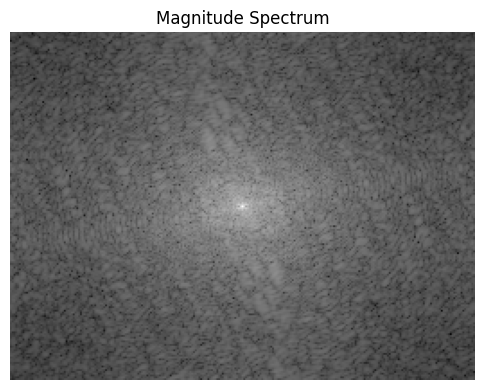

In [69]:
# Compute magnitude spectrum
magnitude_spectrum = 20 * np.log(np.abs(fshift) + 1)

plt.figure(figsize=(6,6))
plt.imshow(magnitude_spectrum, cmap='gray')
plt.title('Magnitude Spectrum')
plt.axis('off')
plt.show()

## 3 Apply a Low-Pass and High-Pass Filter in the Frequency Domain

Create a mask in the frequency domain to filter out high or low frequencies.

In [70]:
rows, cols = image.shape
crow, ccol = rows // 2 , cols // 2

# Create a low-pass filter mask (circle in the center)
mask_lp = np.zeros((rows, cols), np.uint8)
r = 50  # Radius
cv2.circle(mask_lp, (ccol, crow), r, 1, thickness=-1)

# Create high-pass mask as complement
mask_hp = 1 - mask_lp

# Apply the masks
fshift_lp = fshift * mask_lp
fshift_hp = fshift * mask_hp

## 4 Reconstruct the Image from the Filtered Spectrum

To get the filtered image, apply the inverse Fourier transform.


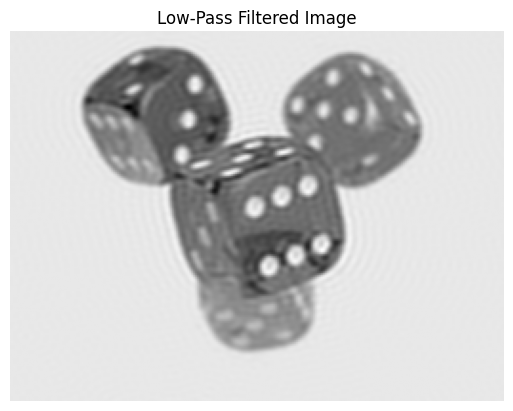

In [71]:
# Inverse shift and IFFT for low-pass
f_ishift_lp = np.fft.ifftshift(fshift_lp)
img_back_lp = np.fft.ifft2(f_ishift_lp)
img_back_lp = np.abs(img_back_lp)

# Display the result
plt.imshow(img_back_lp, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')
plt.show()

## 5 Load an Audio Signal and Compute its Spectrogram

Use the Librosa library to load an audio file and compute the spectrogram using STFT.


In [72]:
#! pip install librosa

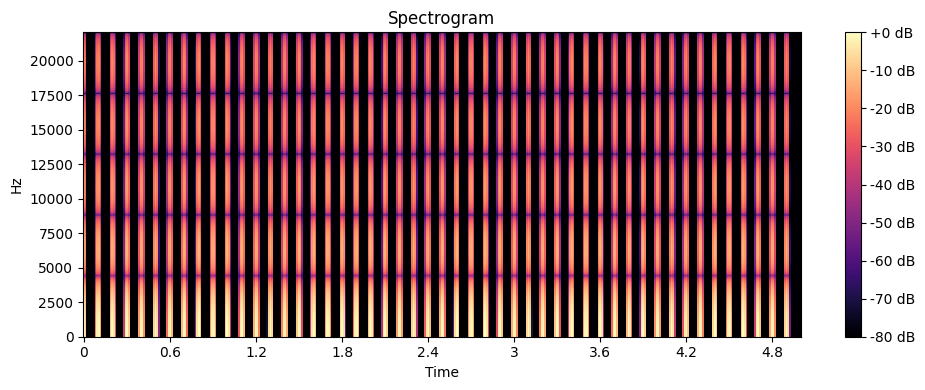

In [73]:
import librosa
import librosa.display

# Load audio file
y, sr = librosa.load('pulse_train.wav', sr=None)

# Compute STFT
D = librosa.stft(y)
S_db = librosa.amplitude_to_db(np.abs(D), ref=np.max)

# Display spectrogram
plt.figure(figsize=(10, 4))
librosa.display.specshow(S_db, sr=sr, x_axis='time', y_axis='hz', cmap='magma')
plt.colorbar(format='%+2.0f dB')
plt.title('Spectrogram')
plt.tight_layout()
plt.show()

## 6 Compare Time-Domain and Frequency-Domain Representations

Plot both the waveform and its corresponding frequency representation.


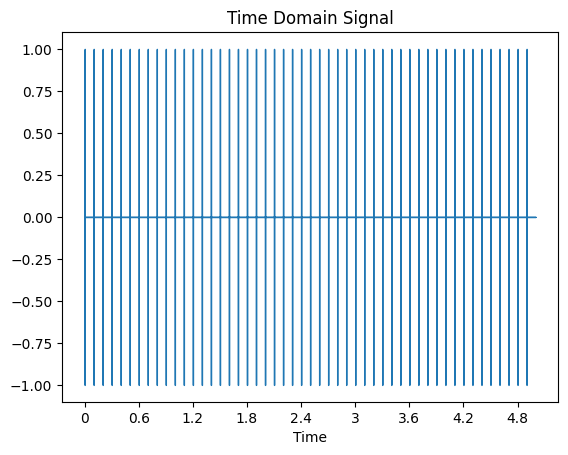

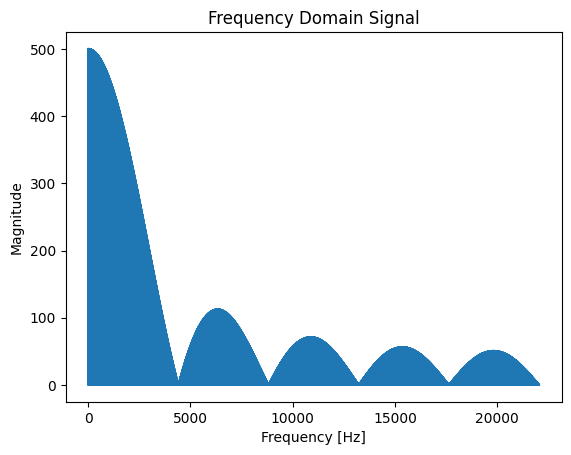

In [74]:
# Plot waveform (time domain)
plt.figure()
librosa.display.waveshow(y, sr=sr)
plt.title('Time Domain Signal')

# Plot magnitude spectrum (frequency domain)
Y = np.fft.fft(y)
freqs = np.fft.fftfreq(len(Y), 1/sr)
plt.figure()
plt.plot(freqs[:len(freqs)//2], np.abs(Y[:len(Y)//2]))
plt.title('Frequency Domain Signal')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Magnitude')
plt.show()

## 7 (Optional) Apply a Denoising Filter Using Frequency Domain Processing

Simple denoising can be performed by suppressing very high-frequency components.


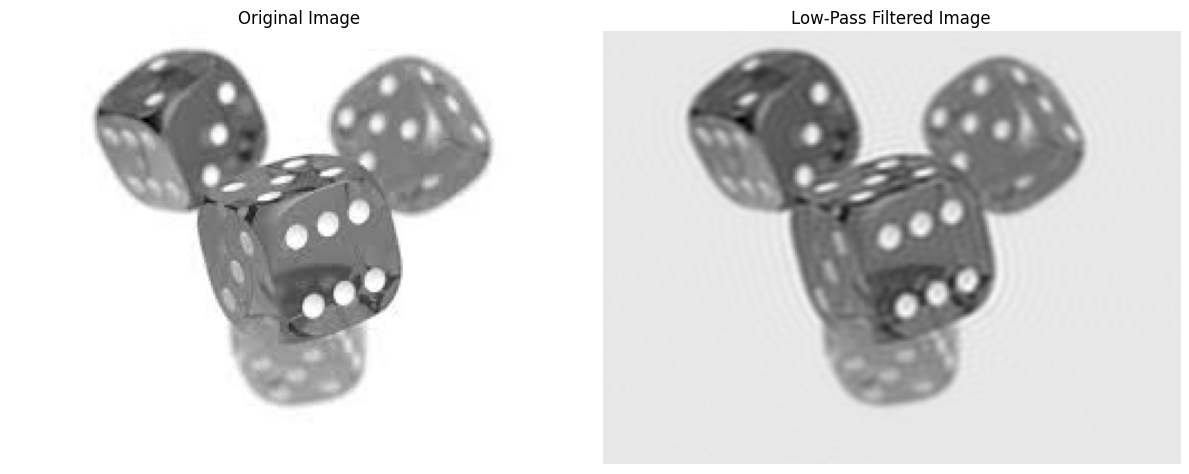

In [75]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load image in grayscale
image = cv2.imread('PNG_transparency_demonstration_1.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Compute 2D FFT and shift zero frequency to the center
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Create a low-pass mask
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2
r = 50  # radius of the low-pass circle

# Create a float32 mask (same shape, values between 0 and 1)
mask_lp = np.zeros((rows, cols), dtype=np.float32)
cv2.circle(mask_lp, (ccol, crow), r, 1, thickness=-1)

# Apply mask to the shifted FFT
fshift_lp = fshift * mask_lp

# Inverse shift and inverse FFT to reconstruct image
f_ishift = np.fft.ifftshift(fshift_lp)
img_back = np.fft.ifft2(f_ishift)
img_back = np.abs(img_back)  # Get magnitude (real part only)

# Display original and filtered image
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_back, cmap='gray')
plt.title('Low-Pass Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()


## Band-Pass Filter for Image

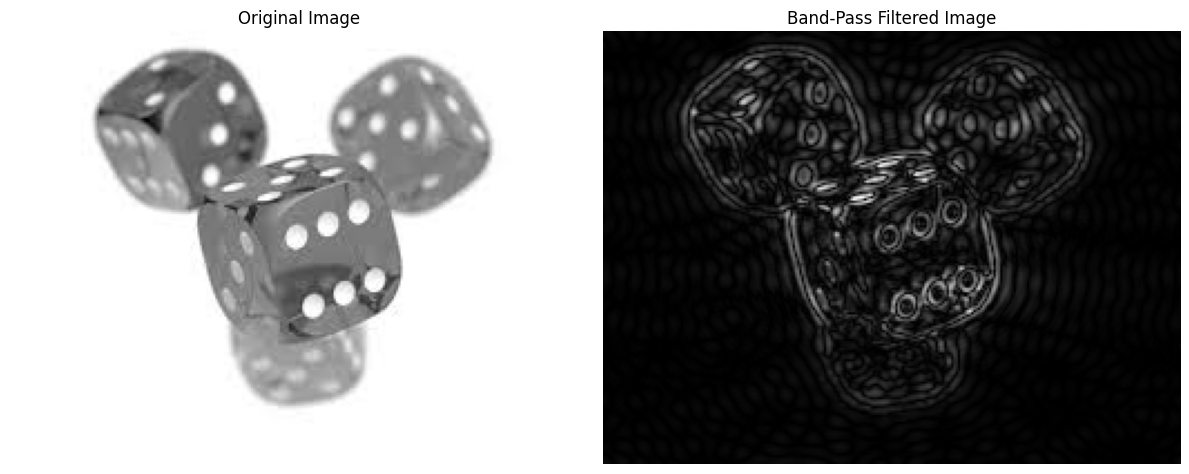

In [76]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

# Load image in grayscale
image = cv2.imread('PNG_transparency_demonstration_1.png', cv2.IMREAD_GRAYSCALE)
if image is None:
    raise ValueError("Image not found. Check the file path.")

# Compute 2D FFT and shift zero frequency to the center
f = np.fft.fft2(image)
fshift = np.fft.fftshift(f)

# Get dimensions and center
rows, cols = image.shape
crow, ccol = rows // 2, cols // 2

# Define inner and outer radii for the band-pass filter
r1 = 20   # Inner radius (removes low frequencies)
r2 = 80   # Outer radius (removes high frequencies)

# Create band-pass mask: circle ring between r1 and r2
mask = np.zeros((rows, cols), dtype=np.float32)
cv2.circle(mask, (ccol, crow), r2, 1, thickness=-1)    # Outer circle (everything inside is 1)
cv2.circle(mask, (ccol, crow), r1, 0, thickness=-1)    # Inner circle (set center to 0 again)

# Apply the band-pass filter
fshift_bp = fshift * mask

# Inverse shift and inverse FFT to reconstruct image
f_ishift = np.fft.ifftshift(fshift_bp)
img_bandpass = np.fft.ifft2(f_ishift)
img_bandpass = np.abs(img_bandpass)

# Display results
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(img_bandpass, cmap='gray')
plt.title('Band-Pass Filtered Image')
plt.axis('off')

plt.tight_layout()
plt.show()


# Appendix

In [77]:
import numpy as np
import cv2
from scipy.signal import chirp
from scipy.io.wavfile import write

## 1. Checkerboard Image and Sine Sweep

In [78]:
# Image: Checkerboard
def generate_checkerboard(size=256, squares=8):
    block = np.kron([[1, 0] * (squares // 2), [0, 1] * (squares // 2)] * (squares // 2),
                    np.ones((size//squares, size//squares)))
    cv2.imwrite('checkerboard.png', (block * 255).astype(np.uint8))

# Audio: Sine sweep
def generate_sine_sweep(f0=100, f1=2000, duration=5, fs=44100):
    t = np.linspace(0, duration, int(fs * duration))
    y = chirp(t, f0=f0, f1=f1, t1=duration, method='linear')
    write('sine_sweep.wav', fs, (y * 32767).astype(np.int16))
    


## 2. Shapes Image and Beep Pattern

In [79]:

# Image: Geometric shapes
def generate_shapes(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.rectangle(img, (30, 30), (100, 100), 255, -1)
    cv2.circle(img, (180, 80), 40, 255, -1)
    cv2.line(img, (50, 200), (200, 220), 255, 3)
    cv2.imwrite('shapes.png', img)

# Audio: Repeated beeps
def generate_beep(fs=44100):
    t_beep = np.linspace(0, 0.2, int(fs * 0.2))
    beep = 0.5 * np.sin(2 * np.pi * 1000 * t_beep)
    silence = np.zeros(int(fs * 0.2))
    signal = np.tile(np.concatenate((beep, silence)), 10)
    write('beep_pattern.wav', fs, (signal * 32767).astype(np.int16))
    

## 3. Barcode Image and White Noise

In [80]:
# Image: Barcode
def generate_barcode(rows=256, cols=256, bars=60):
    img = np.ones((rows, cols), dtype=np.uint8) * 255
    for i in range(0, cols, cols // bars):
        cv2.rectangle(img, (i, 0), (i + cols // (2 * bars), rows), 0, -1)
    cv2.imwrite('barcode.png', img)

generate_barcode(rows=256, cols=256, bars=60)    
    
# Audio: White noise
def generate_white_noise(duration=5, fs=44100):
    noise = np.random.normal(0, 1, int(fs * duration))
    write('white_noise.wav', fs, (noise * 32767).astype(np.int16))


## 4. Blurred Dot and Low-Frequency Hum

In [81]:
from scipy.ndimage import gaussian_filter

# Image: Blurred dot
def generate_blurred_dot(size=256):
    img = np.zeros((size, size))
    img[size//2, size//2] = 1
    blurred = gaussian_filter(img, sigma=10)
    cv2.imwrite('blurred_dot.png', (blurred * 255).astype(np.uint8))

# Audio: 50Hz hum
def generate_hum(freq=50, duration=5, fs=44100):
    t = np.linspace(0, duration, int(fs * duration))
    y = 0.5 * np.sin(2 * np.pi * freq * t)
    write('hum.wav', fs, (y * 32767).astype(np.int16))

## 5. Ring Image and Harmonic Tones

In [82]:
# Image: Ring
def generate_ring(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(img, (size//2, size//2), 60, 255, thickness=5)
    cv2.imwrite('ring.png', img)

# Audio: 440 Hz and 880 Hz
def generate_harmonics(fs=44100, duration=3):
    t = np.linspace(0, duration, int(fs * duration))
    y = 0.5 * np.sin(2 * np.pi * 440 * t) + 0.5 * np.sin(2 * np.pi * 880 * t)
    write('harmonics.wav', fs, (y * 32767).astype(np.int16))

## 6. Diagonal Stripes and Square Wave

In [83]:
# Diagonal stripes
def generate_diagonal_stripes(size=256, spacing=20):
    img = np.zeros((size, size), dtype=np.uint8)
    for i in range(0, size, spacing):
        cv2.line(img, (i, 0), (0, i), 255, 1)
    cv2.imwrite('diagonal_stripes.png', img)

# Square wave audio
from scipy.signal import square
def generate_square_wave(freq=500, duration=3, fs=44100):
    t = np.linspace(0, duration, int(fs * duration))
    y = 0.5 * square(2 * np.pi * freq * t)
    write('square_wave.wav', fs, (y * 32767).astype(np.int16))

## 7. Random Noise Image and AM Sine Wave

In [84]:
# Image: Smoothed noise
def generate_smoothed_noise(size=256):
    from scipy.ndimage import gaussian_filter
    noise = np.random.rand(size, size)
    smooth = gaussian_filter(noise, sigma=10)
    cv2.imwrite('smoothed_noise.png', (smooth * 255).astype(np.uint8))

# Audio: AM (Amplitude Modulation)
def generate_am_signal(fs=44100, duration=5):
    t = np.linspace(0, duration, int(fs * duration))
    carrier = np.sin(2 * np.pi * 1000 * t)
    modulator = (1 + np.sin(2 * np.pi * 5 * t)) / 2
    y = carrier * modulator
    write('am_signal.wav', fs, (y * 32767).astype(np.int16))

## 8. Fractal Noise and Impulse Train

In [85]:

# Image: Fractal-like noise
def generate_fractal_noise(size=256):
    from scipy.ndimage import gaussian_filter
    noise = gaussian_filter(np.random.rand(size, size), sigma=8)
    cv2.imwrite('fractal_noise.png', (noise * 255).astype(np.uint8))

# Audio: Repeating impulses
def generate_impulse_train(fs=44100, duration=5, interval=1):
    signal = np.zeros(int(fs * duration))
    for i in range(0, int(duration), interval):
        signal[i * fs] = 1.0
    write('impulse_train.wav', fs, (signal * 32767).astype(np.int16))

## 9. Grid Pattern and Fading Sine Wave

In [86]:
# Image: Grid with gaps
def generate_broken_grid(size=256, step=32):
    img = np.zeros((size, size), dtype=np.uint8)
    for i in range(0, size, step):
        if i % 64 != 0:
            img[i, :] = 255
            img[:, i] = 255
    cv2.imwrite('broken_grid.png', img)

# Audio: Fade-in sine
def generate_fadein_sine(fs=44100, duration=5, freq=440):
    t = np.linspace(0, duration, int(fs * duration))
    envelope = np.linspace(0, 1, len(t))
    y = envelope * np.sin(2 * np.pi * freq * t)
    write('fadein_sine.wav', fs, (y * 32767).astype(np.int16))

## 10. Symmetric Shapes and Alternating Noise

In [87]:

# Image: Symmetric pattern
def generate_symmetric_shapes(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(img, (size//4, size//2), 30, 255, -1)
    cv2.circle(img, (3*size//4, size//2), 30, 255, -1)
    cv2.line(img, (size//2, 0), (size//2, size), 255, 2)
    cv2.imwrite('symmetric_shapes.png', img)

# Audio: Alternating noise and silence
def generate_onoff_noise(fs=44100, duration=5):
    noise = np.random.normal(0, 0.5, fs//2)
    silence = np.zeros(fs//2)
    pattern = np.tile(np.concatenate([noise, silence]), duration // 1)
    write('onoff_noise.wav', fs, (pattern * 32767).astype(np.int16))

## 11. Horizontal Edge and Pulse Train

In [88]:

# Image: Half black, half white
def generate_edge_image(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    img[:, size//2:] = 255
    cv2.imwrite('half_edge.png', img)

# Audio: Pulse train
def generate_pulse_train(fs=44100, duration=5):
    signal = np.zeros(int(fs * duration))
    for i in range(0, len(signal), fs//10):
        signal[i:i+10] = 1
    write('pulse_train.wav', fs, (signal * 32767).astype(np.int16))

## 12. Triangle Image and Triangle Wave Audio

In [89]:

from scipy.signal import sawtooth

# Image: Triangle waveform pattern (horizontal)
def generate_triangle_pattern(size=256):
    img = np.tile(np.linspace(0, 255, size, dtype=np.uint8), (size, 1))
    triangle = np.abs((img.astype(float) - 127.5) * 2)
    cv2.imwrite('triangle_pattern.png', triangle.astype(np.uint8))

# Audio: Triangle wave
def generate_triangle_wave(freq=500, duration=3, fs=44100):
    t = np.linspace(0, duration, int(fs * duration))
    y = 0.5 * sawtooth(2 * np.pi * freq * t, 0.5)
    write('triangle_wave.wav', fs, (y * 32767).astype(np.int16))

## 13. Vertical Line and High-Frequency Burst

In [90]:

# Image: Vertical line in center
def generate_vertical_line(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    img[:, size//2] = 255
    cv2.imwrite('vertical_line.png', img)

# Audio: High-frequency burst
def generate_burst(fs=44100, duration=2, freq=3000):
    t = np.linspace(0, duration, int(fs * duration))
    y = np.zeros_like(t)
    y[:fs//5] = 0.5 * np.sin(2 * np.pi * freq * t[:fs//5])
    write('burst.wav', fs, (y * 32767).astype(np.int16))

## 14. Gradient and Chirp

In [91]:

# Image: Horizontal gradient
def generate_gradient(size=256):
    img = np.tile(np.linspace(0, 255, size, dtype=np.uint8), (size, 1))
    cv2.imwrite('gradient.png', img)

# Audio: Linear chirp
def generate_chirp(f0=100, f1=8000, duration=3, fs=44100):
    from scipy.signal import chirp
    t = np.linspace(0, duration, int(fs * duration))
    y = chirp(t, f0=f0, f1=f1, t1=duration, method='linear')
    write('chirp.wav', fs, (y * 32767).astype(np.int16))

## 15. Overlapping Shapes and Tone + Noise

In [92]:

# Image: Overlapping shapes
def generate_overlapping_shapes(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    cv2.circle(img, (90, 90), 40, 255, -1)
    cv2.rectangle(img, (100, 100), (180, 180), 255, -1)
    cv2.imwrite('overlapping_shapes.png', img)

# Audio: Sine tone + noise
def generate_tone_noise_mix(fs=44100, duration=3):
    t = np.linspace(0, duration, int(fs * duration))
    tone = 0.4 * np.sin(2 * np.pi * 440 * t)
    noise = 0.6 * np.random.normal(0, 1, len(t))
    mix = tone + noise
    write('tone_noise_mix.wav', fs, (mix * 32767 / np.max(np.abs(mix))).astype(np.int16))

In [93]:
import numpy as np
import cv2
from scipy.io.wavfile import write

# Image: Half black, half white (horizontal edge)
def generate_edge_image(size=256):
    img = np.zeros((size, size), dtype=np.uint8)
    img[:, size//2:] = 255
    cv2.imwrite('half_edge.png', img)

# Audio: Pulse train
def generate_pulse_train(fs=44100, duration=5):
    signal = np.zeros(int(fs * duration))
    pulse_length = 10
    interval = fs // 10  # impulsy co 0.1s

    for i in range(0, len(signal), interval):
        signal[i:i + pulse_length] = 1

    write('pulse_train.wav', fs, (signal * 32767).astype(np.int16))


# Wywołanie funkcji
generate_edge_image()
generate_pulse_train()
